## 1. Librerías y parámetros

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import reverse_geocoder as rg


pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

## 2. Data Pre-processing

In [2]:
#hacemos lectura de los datos con pandas
test_henry = pd.read_parquet("d:/Henry/PI 02/Data/test.parquet")
df = pd.read_parquet("d:/Henry/PI 02/Data/train.parquet")

#crear variable binaria sobre columnas "price" para el modelo de clasificación
def precio_binario(df):
    try:
        if df["price"] <= 999:
            return 1
        else: return 0
    except: return 0

df["category_price"] = df.apply(precio_binario,axis=1)

<AxesSubplot:>

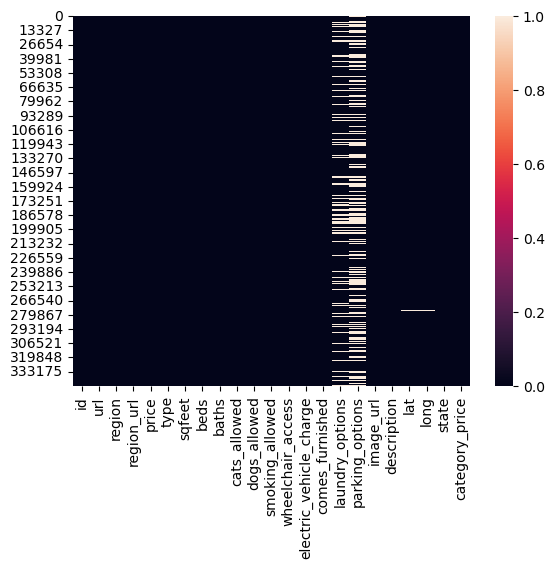

In [3]:
#ambos datasets presentan muchos valores nulos para la columna parking_options
sns.heatmap(df.isnull())

<AxesSubplot:>

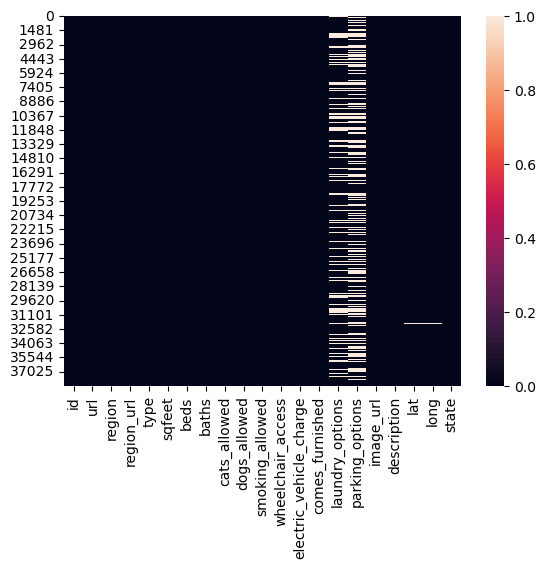

In [4]:
sns.heatmap(test_henry.isnull())

In [5]:
#la mitad de registros no tienen datos. Anulamos la columna parking
df.parking_options.isnull().value_counts()
df.drop(["parking_options"],inplace=True,axis=1)

In [6]:
#el 20% de los datos de laundry estan vacios. 
print(len(df),"\n",df["laundry_options"].isnull().value_counts())

346479 
 False    275308
True      71171
Name: laundry_options, dtype: int64


<AxesSubplot:xlabel='laundry_options', ylabel='count'>

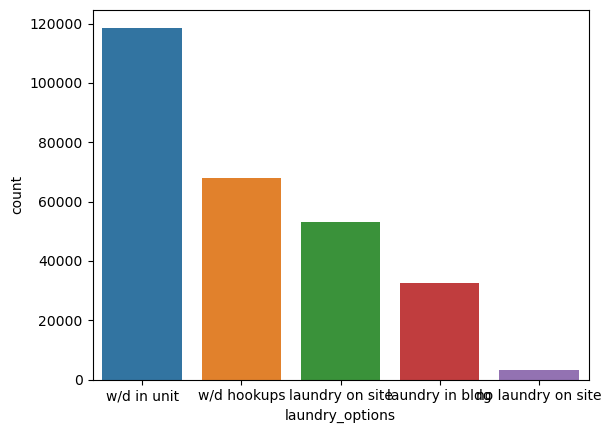

In [7]:
sns.countplot(x=df["laundry_options"])

In [8]:
#estamos frente al 20% de datos faltantes para 1 columna, lo que podemos realizar es llenar los missing values con la moda, o quitar los valores faltantes. Haré lo ultimo  
df['laundry_options'].fillna(df['laundry_options'].mode()[0], inplace=True)

<AxesSubplot:>

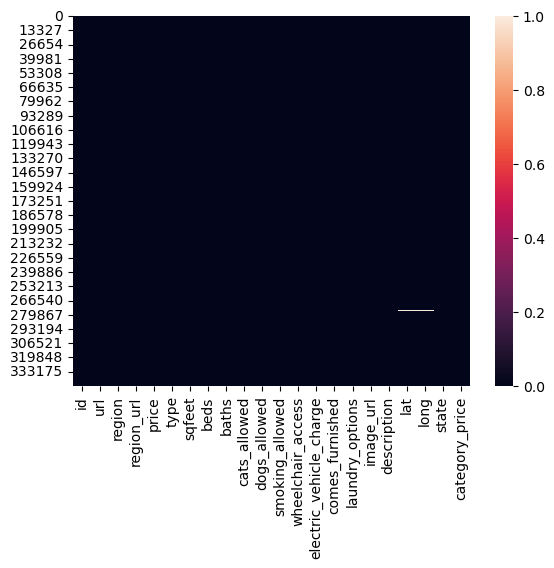

In [9]:
sns.heatmap(df.isnull())

In [10]:
#eliminamos las los nulos pendientes de lat y long
df.dropna(inplace=True)

<AxesSubplot:>

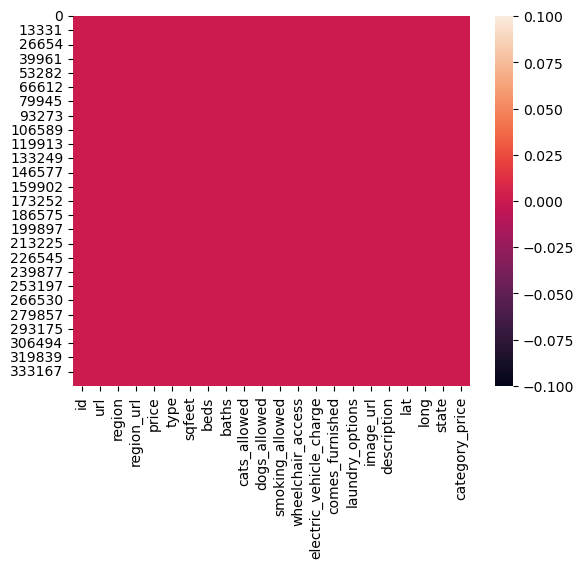

In [11]:
sns.heatmap(df.isnull())

In [12]:
# Retiramos las columnas que no tomaremos en cuenta en esta oportunidad 
df.drop(["id","url","region","region_url","description"],inplace=True,axis=1)
# recreamos las modificaciones en test_henry para igualar los datasets
test_henry.drop(["id","url","region","region_url","description","parking_options"],inplace=True,axis=1)
test_henry['laundry_options'].fillna(test_henry['laundry_options'].mode()[0], inplace=True)


In [13]:
#Eliminamos las columnas con valores duplicados posterior a eliminar las columnas
inicio = len(df)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True)
print(inicio,len(df))

344755 253260


<AxesSubplot:xlabel='category_price', ylabel='count'>

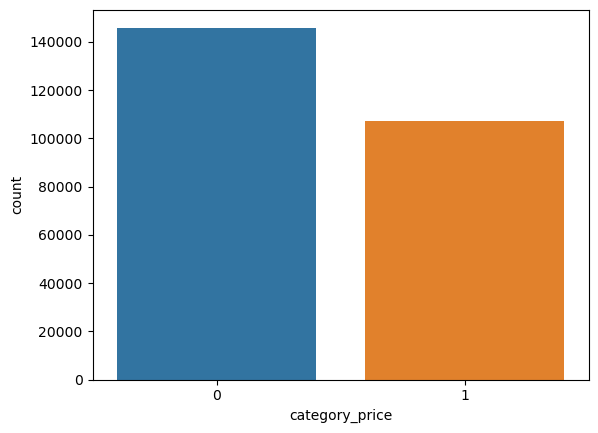

In [14]:
#primero vamos analizar la variable dependiente, vemos que el dataset no esta desbalanceado, por lo cual mantendremos la proporción en el split sin problemas. 
sns.countplot(x=df["category_price"])

(0.0, 10000.0)

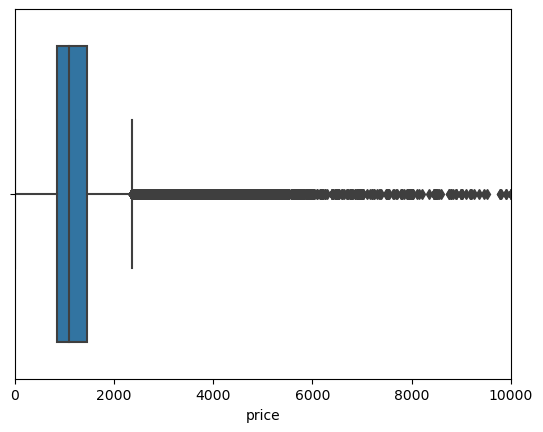

In [15]:
#claramente tenemos outliers, pero vamos atacar primero desde las features

sns.boxplot(data=df,x=df["price"])
plt.xlim(0,10000)

In [16]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

df_clean = pd.DataFrame()

for i,j in enumerate(df["type"].unique()):
    temp_drop = remove_outlier_IQR(df[df["type"]==j]["price"])
    df_clean = pd.concat([df_clean,temp_drop])

df = df[df.index.isin(df_clean.index.to_list())]

<AxesSubplot:xlabel='price'>

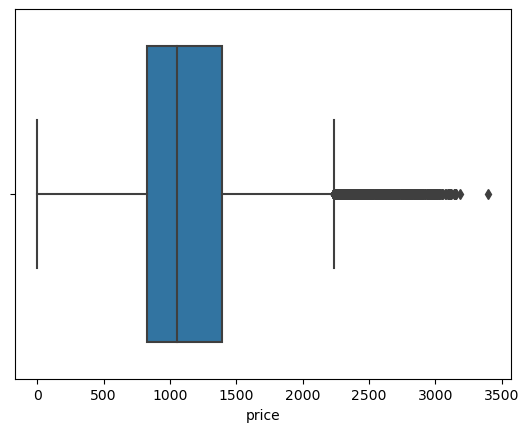

In [17]:
sns.boxplot(data=df,x=df["price"])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'house'),
  Text(1, 0, 'apartment'),
  Text(2, 0, 'duplex'),
  Text(3, 0, 'loft'),
  Text(4, 0, 'condo'),
  Text(5, 0, 'manufactured'),
  Text(6, 0, 'townhouse'),
  Text(7, 0, 'in-law'),
  Text(8, 0, 'cottage/cabin'),
  Text(9, 0, 'flat'),
  Text(10, 0, 'assisted living'),
  Text(11, 0, 'land')])

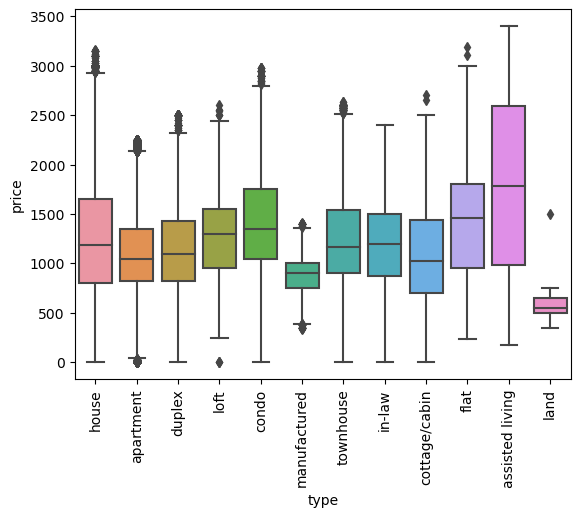

In [18]:
sns.boxplot(data=df,y=df["price"],x=df["type"])
plt.xticks(rotation=90)

<AxesSubplot:xlabel='sqfeet', ylabel='price'>

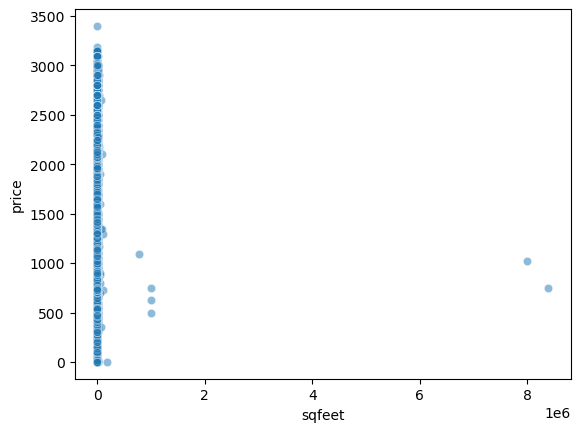

In [19]:
sns.scatterplot(data=df,x="sqfeet",y="price",alpha=0.5)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

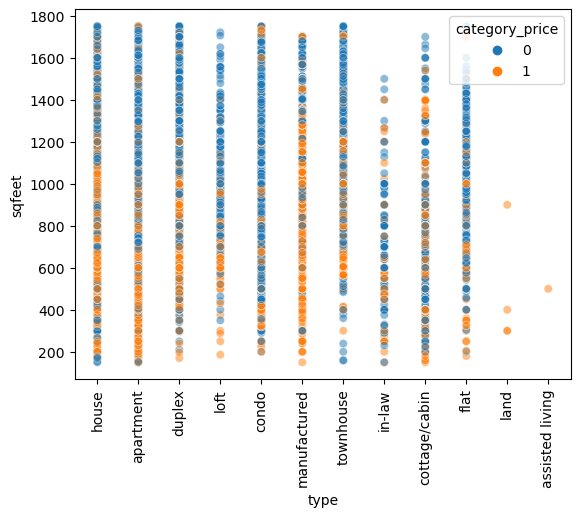

In [20]:
df = df[df.index.isin(remove_outlier_IQR(df["sqfeet"]).index.to_list())]
sns.scatterplot(data=df,x="type",y="sqfeet",alpha=0.5,hue="category_price")
plt.xticks(rotation=90)

<AxesSubplot:>

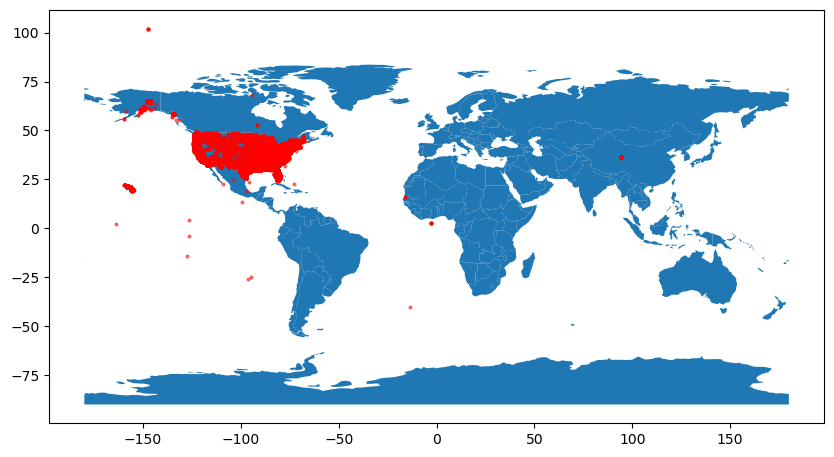

In [21]:
#vamos a revisar las ubicaciones, debemos validar que tengamos solo de EEUU
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=15,alpha=0.5)

Como se puede observar en el gráfico, existe valores externos a eeuu

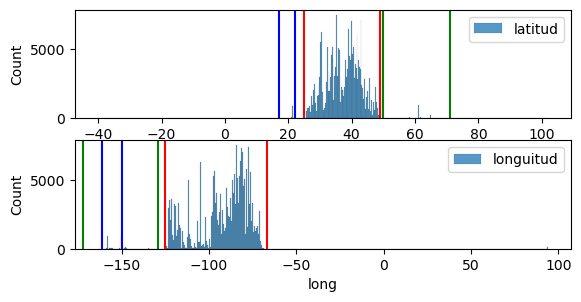

In [22]:
#Usando las siguientes reglas, puedo deducir que si las coordenadas se encuentran dentro de estos parametros es bastante posible que se traten de coordenadas dentro de EEUU.

#pais
# norte: lat: +49
# Sur:  lat: +25
# oeste: long: -125
# este: long: -67

#alaska
# norte:71
# sur: 50
# oeste: -172
# este: -129

#hawai
# norte:22
# sur: 17
# oeste: -161
# este: -150

plt.subplot(3,1,1)
sns.histplot(data=df,x="lat",label="latitud")
plt.axvline(49,c="red")
plt.axvline(25,c="red")
plt.axvline(71,c="g")
plt.axvline(50,c="g")
plt.axvline(22,c="b")
plt.axvline(17,c="b")

plt.legend()
plt.subplot(3,1,2)
sns.histplot(data=df,x="long",label="longuitud")
plt.axvline(-125,c="red")
plt.axvline(-67,c="red")
plt.axvline(-172,c="g")
plt.axvline(-129,c="g")
plt.axvline(-161,c="b")
plt.axvline(-150,c="b")

plt.legend()

vamos a limpiar un poco los data points que esten fuera del territorio EEUU

In [23]:
def coordenadas(df):
    try: return (df["lat"],df["long"])
    except: return np.nan

len(df)
df.dropna(subset=["lat"],inplace=True)
df.dropna(subset=["long"],inplace=True)
df.reset_index(inplace=True,drop=True)

pais =   df[(df['lat'].between(25,49))&(df['long'].between(-125,-67))]
alaska = df[(df['lat'].between(50,71))&(df['long'].between(-180,-129))]
hawai =  df[(df['lat'].between(17,22))&(df['long'].between(-161,-150))]
eeuu = pd.concat([pais,alaska,hawai])

not_eeuu = df.loc[~df.index.isin(eeuu.index.to_list())]

para aquellos datapoints que quedaron fuera del filtro anterior por latitud y longitud, vamos a pasarle el método rg.search que devuelve una trama de texto con paises. Si son de EEUU, los regresamos

In [24]:
#asignamos el pais a cada registro del dataset.
####row_country = not_eeuu["coordenadas_tupla"].map(rg.search)
#lo guardo, ya que generar esto demoró 10 min para 450 registros
####row_country.to_csv("paises_csv.csv")

from ast import literal_eval

revision_pais = pd.read_csv("paises_csv.csv",index_col=0,converters={"coordenadas_tupla": literal_eval})
revision_pais["country"] = revision_pais.apply(lambda df: df["coordenadas_tupla"][0]["cc"],axis=1)
eeuu_revisado = not_eeuu[not_eeuu.index.isin(revision_pais[revision_pais["country"]=="US"].index)]
df_eeuu = pd.concat([eeuu_revisado,eeuu])
df_eeuu.sort_index(inplace=True)
df_eeuu.reset_index(drop=True,inplace=True)
df_eeuu.drop(columns=["geometry"],inplace=True)

<AxesSubplot:>

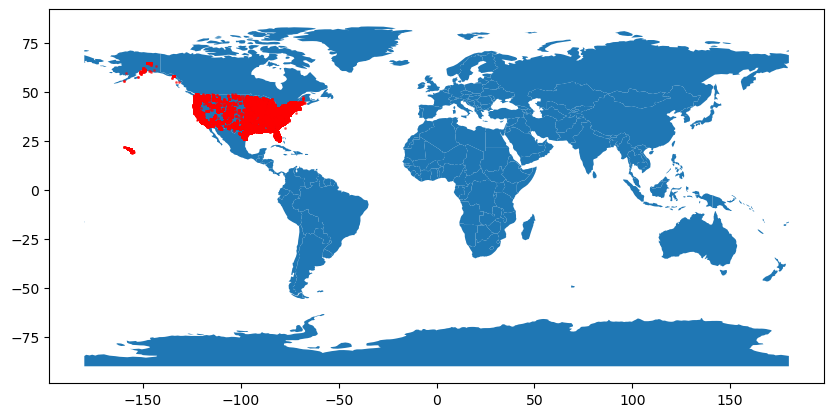

In [25]:
#vamos a revisar las ubicaciones, debemos validar que tengamos solo de EEUU
geometry = [Point(xy) for xy in zip(df_eeuu['long'], df_eeuu['lat'])]
gdf = GeoDataFrame(df_eeuu, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=5,alpha=0.5)

<AxesSubplot:xlabel='long', ylabel='lat'>

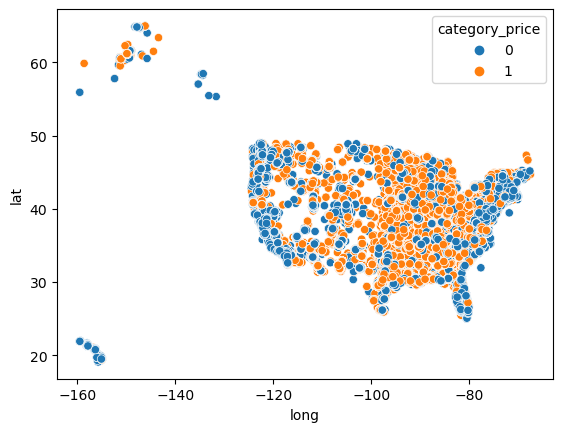

In [26]:
sns.scatterplot(data=df_eeuu,x="long",y="lat",hue="category_price")

In [52]:
#quitamos la columna adicional que creamos para el mapa, para que este igual que henry_test
df_eeuu.drop(["geometry"],axis=1,inplace=True)

In [28]:
df_eeuu.describe()

price         sqfeet           beds          baths  \
count  229898.000000  229898.000000  229898.000000  229898.000000   
mean     1119.584833     944.403562       1.826506       1.432640   
std       410.207298     273.752667       2.235439       0.551025   
min         0.000000     150.000000       0.000000       0.000000   
25%       825.000000     748.000000       1.000000       1.000000   
50%      1049.000000     926.000000       2.000000       1.000000   
75%      1360.000000    1109.000000       2.000000       2.000000   
max      3187.000000    1750.000000    1000.000000      25.000000   

        cats_allowed   dogs_allowed  smoking_allowed  wheelchair_access  \
count  229898.000000  229898.000000    229898.000000      229898.000000   
mean        0.723421       0.701424         0.728166           0.075647   
std         0.447308       0.457634         0.444906           0.264432   
min         0.000000       0.000000         0.000000           0.000000   
25%         0.000000       0.000000         0.000000           0.000000   
50%         1.000000       1.000000         1.000000           0.000000   
75%         1.000000       1.000000         1.000000           0.000000   
max         1.000000       1.000000         1.000000           1.000000   

       electric_vehicle_charge  comes_furnished            lat           long  \
count            229898.000000    229898.000000  229898.000000  229898.000000   
mean                  0.011440         0.041632      37.396789     -92.743491   
std                   0.106344         0.199746       5.639813      15.814742   
min                   0.000000         0.000000      19.100200    -159.530000   
25%                   0.000000         0.000000      33.480500     -98.655500   
50%                   0.000000         0.000000      37.974400     -87.685700   
75%                   0.000000         0.000000      41.443700     -81.181800   
max                   1.000000         1.000000      64.993700     -67.482000   

       category_price  
count   229898.000000  
mean         0.455428  
std          0.498010  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
max          1.000000

<AxesSubplot:xlabel='beds', ylabel='count'>

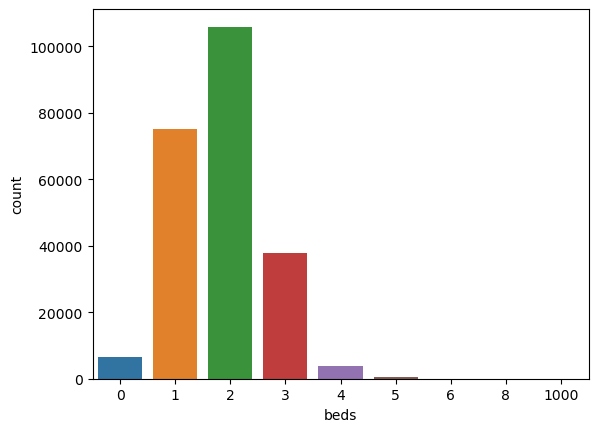

In [29]:
sns.countplot(x=df_eeuu["beds"])


<AxesSubplot:xlabel='beds', ylabel='count'>

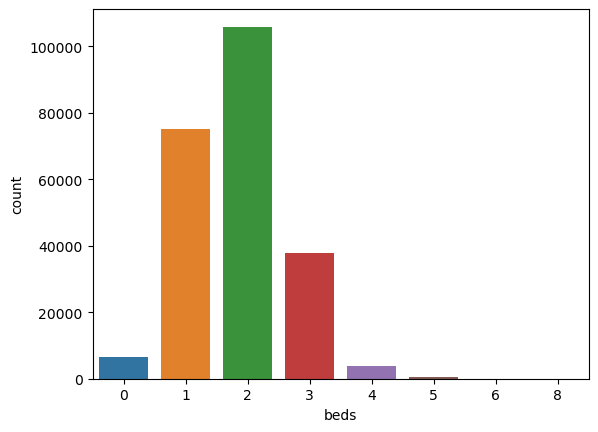

In [30]:
df_eeuu.drop(df_eeuu[df_eeuu["beds"]>9].index,inplace=True)
sns.countplot(x=df_eeuu["beds"])

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

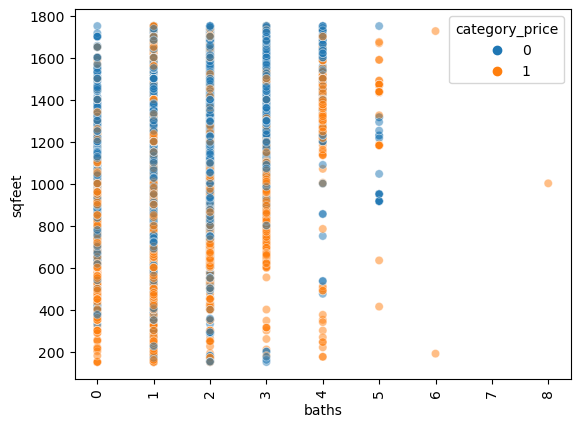

In [31]:
df_eeuu["baths"] = df_eeuu["baths"].apply(lambda x: math.ceil(x))
test_henry["baths"] = test_henry["baths"].apply(lambda x: math.ceil(x))

sns.scatterplot(data=df_eeuu,x="baths",y="sqfeet",alpha=0.5, hue="category_price")
plt.xticks(rotation=90)

Tener gato o perro no tiene mucha relación con que tan cara o no es la vivienda

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

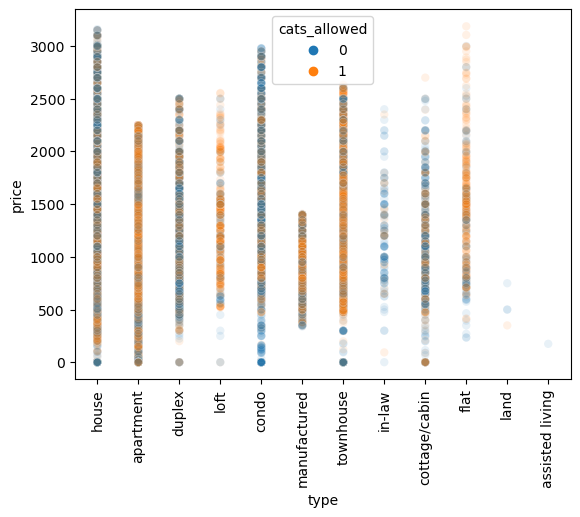

In [32]:
sns.scatterplot(data=df_eeuu,x="type",y="price", alpha=0.1, color="b", hue="cats_allowed")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

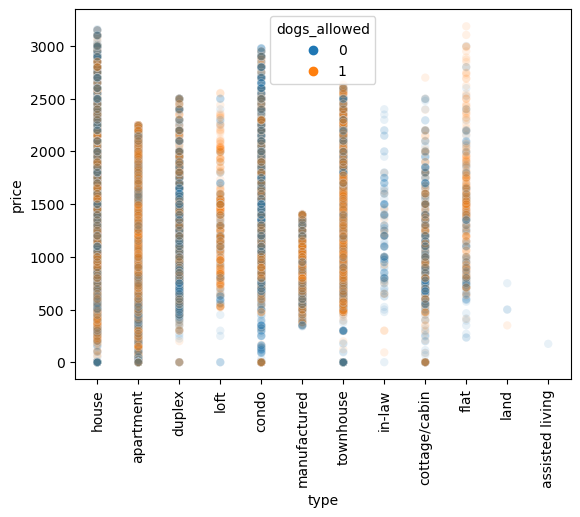

In [33]:
sns.scatterplot(data=df_eeuu,x="type",y="price", alpha=0.1, color="b", hue="dogs_allowed")
plt.xticks(rotation=90)

In [34]:
#pero vamos a juntar la variable cat_dog_allowed -> como variable de permitido animales
def animales(df):
    if df["cats_allowed"] == 1 or df["dogs_allowed"] == 1:
        return 1
    else: return 0
df_eeuu["cat_dog_allowed"] = df_eeuu.apply(animales,axis=1)
test_henry["cat_dog_allowed"] = test_henry.apply(animales,axis=1)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

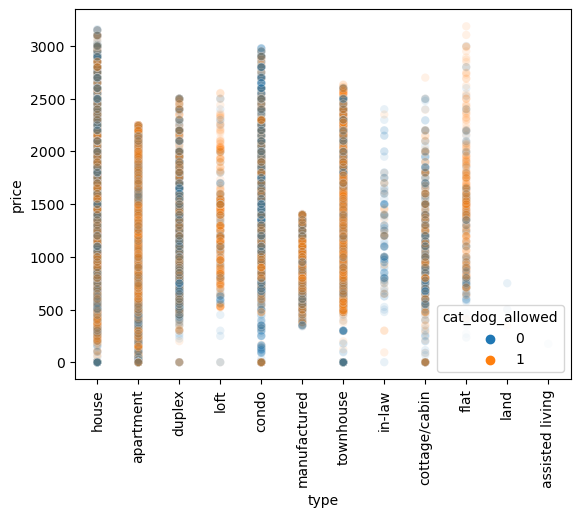

In [35]:
sns.scatterplot(data=df_eeuu,x="type",y="price", alpha=0.1, color="b", hue="cat_dog_allowed")
plt.xticks(rotation=90)

En casi todos los sitios esta permitido fumar, así que no creo que aporte al modelo

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

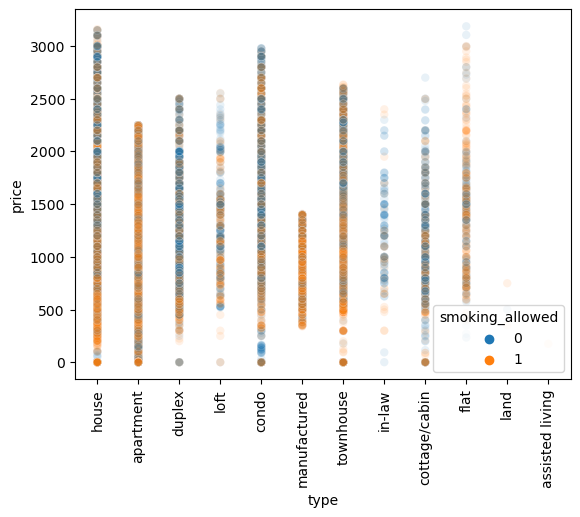

In [36]:
sns.scatterplot(data=df_eeuu,x="type",y="price", hue="smoking_allowed",alpha=0.1, color="b")
plt.xticks(rotation=90)

Tener acceso de sillas de ruedas parece que sí esta relacionado con el precio

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

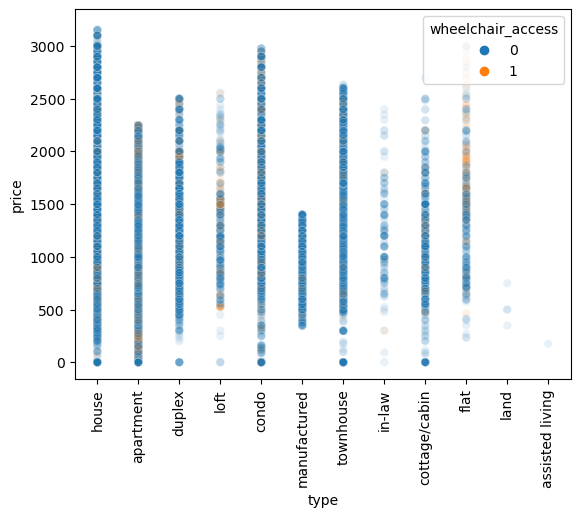

In [37]:
sns.scatterplot(data=df_eeuu,x="type",y="price", hue="wheelchair_access",alpha=0.1, color="b")
plt.xticks(rotation=90)

In [38]:
df.columns

Index(['price', 'type', 'sqfeet', 'beds', 'baths', 'cats_allowed',
       'dogs_allowed', 'smoking_allowed', 'wheelchair_access',
       'electric_vehicle_charge', 'comes_furnished', 'laundry_options',
       'image_url', 'lat', 'long', 'state', 'category_price', 'geometry'],
      dtype='object')

La mayoria parece no tener cargador para vehiculos, entonces el modelo no aprenderá mucho sobre este feature

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

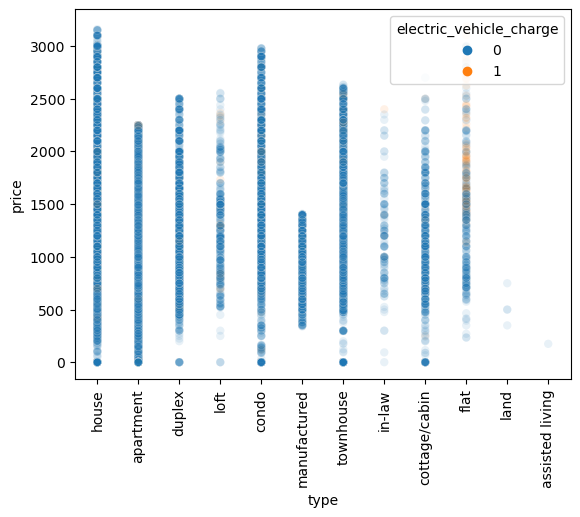

In [39]:
sns.scatterplot(data=df_eeuu,x="type",y="price", hue="electric_vehicle_charge",alpha=0.1, color="b")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

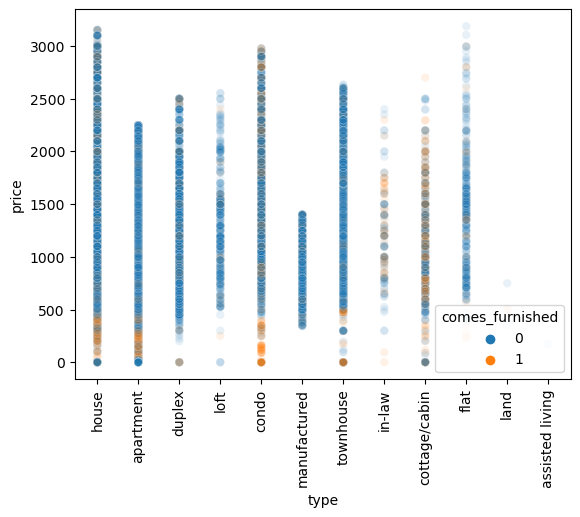

In [40]:
sns.scatterplot(data=df_eeuu,x="type",y="price", hue="comes_furnished",alpha=0.1, color="b")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'w/d in unit'),
  Text(1, 0, 'w/d hookups'),
  Text(2, 0, 'laundry on site'),
  Text(3, 0, 'laundry in bldg'),
  Text(4, 0, 'no laundry on site')])

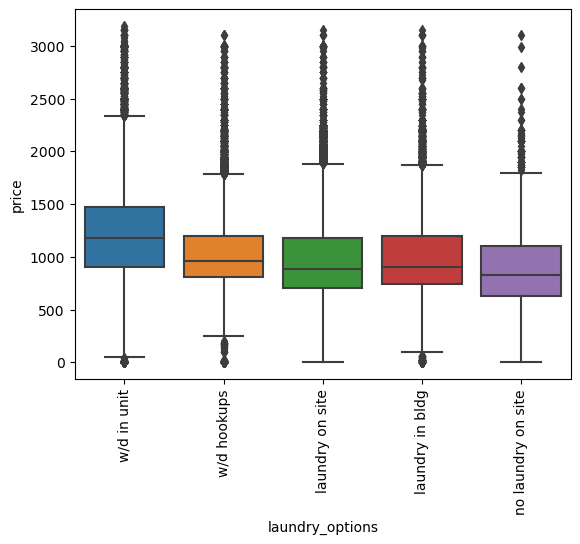

In [41]:
sns.boxplot(data=df_eeuu, y="price", x="laundry_options")
plt.xticks(rotation=90)

C:\Users\wongp\AppData\Local\Temp\ipykernel_9748\2941008954.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ordenado = df_eeuu.groupby(by=["state"]).mean().price.sort_values(ascending=False)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, 'hi'),
  Text(1, 0, 'dc'),
  Text(2, 0, 'ca'),
  Text(3, 0, 'ma'),
  Text(4, 0, 'nh'),
  Text(5, 0, 'ri'),
  Text(6, 0, 'nj'),
  Text(7, 0, 'co'),
  Text(8, 0, 'vt'),
  Text(9, 0, 'wa'),
  Text(10, 0, 'md'),
  Text(11, 0, 'me'),
  Text(12, 0, 'or'),
  Text(13, 0, 'ct'),
  Text(14, 0, 'de'),
  Text(15, 0, 'ut'),
  Text(16, 0, 'fl'),
  Text(17, 0, 'ny'),
  Text(18, 0, 'va'),
  Text(19, 0, 'ak'),
  Text(20, 0, 'mn'),
  Text(21, 0, 'pa'),
  Text(22, 0, 'nv'),
  Text(23, 0, 'id'),
  Text(24, 0, 'sc'),
  Text(25, 0, 'mt'),
  Text(26, 0, 'wi'),
  Text(27, 0, 'az'),
  Text(28, 0, 'tx'),
  Text(29, 0, 'nc'),
  Text(30, 0, 'ga'),
  Text(31, 0, 'nd'),
  Text(32, 0, 'mi'),
  Text(33, 0, 'ne'),
  Text(34, 0, 'tn'),
  Text(35, 0, 'wv'),
  Text(36, 0, 'la'),
  T

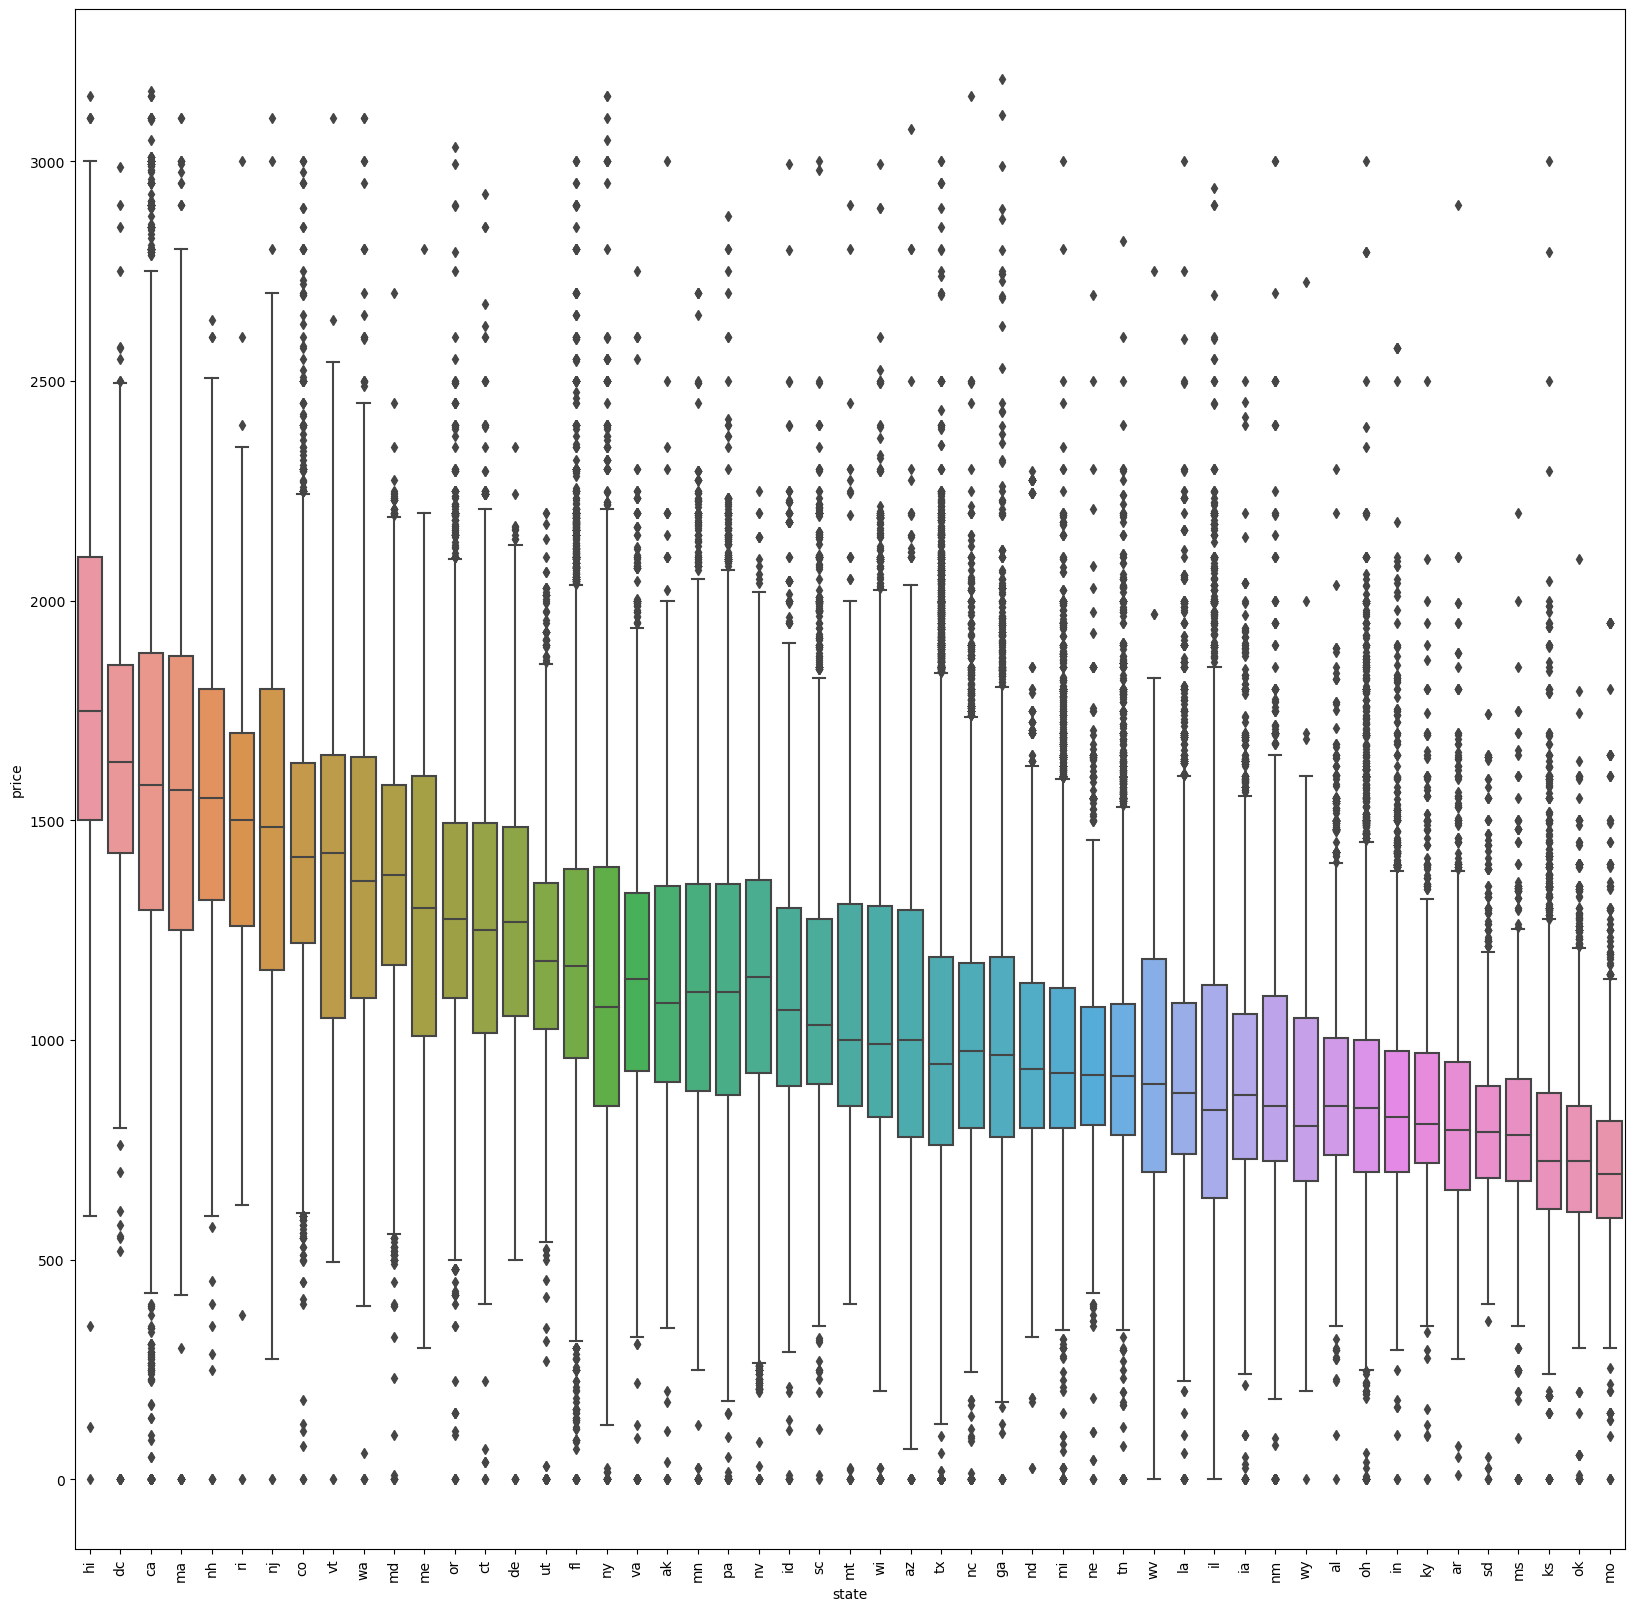

In [42]:
ordenado = df_eeuu.groupby(by=["state"]).mean().price.sort_values(ascending=False)
ordenado.index


plt.figure(figsize=(20,20))
sns.boxplot(data=df_eeuu, y="price", x="state", order=ordenado.index.to_list())
plt.xticks(rotation=90)

In [43]:
df_eeuu.columns

Index(['price', 'type', 'sqfeet', 'beds', 'baths', 'cats_allowed',
       'dogs_allowed', 'smoking_allowed', 'wheelchair_access',
       'electric_vehicle_charge', 'comes_furnished', 'laundry_options',
       'image_url', 'lat', 'long', 'state', 'category_price', 'geometry',
       'cat_dog_allowed'],
      dtype='object')

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled = scaler.fit_transform(np.array(df_eeuu["sqfeet"]).reshape(-1,1))
df_eeuu["scaled_sqfeet"] = scaled
test_henry["scaled_sqfeet"] = scaler.transform(np.array(test_henry["sqfeet"]).reshape(-1,1))

In [45]:
#variables dummies

ohe1 = pd.get_dummies(df_eeuu["type"],prefix="type",drop_first=True)
ohe2 = pd.get_dummies(df_eeuu["beds"],prefix="beds",drop_first=True)
ohe3 = pd.get_dummies(df_eeuu["baths"],prefix="baths",drop_first=True)
ohe4 = pd.get_dummies(df_eeuu["laundry_options"],prefix="laundry",drop_first=True)
ohe5 = pd.get_dummies(df_eeuu["state"],prefix="state",drop_first=True)

df_eeuu = pd.concat([df_eeuu,ohe1,ohe2,ohe3,ohe4,ohe5],axis=1)


ohe6 = pd.get_dummies(test_henry["type"],prefix="type",drop_first=True)
ohe7 = pd.get_dummies(test_henry["beds"],prefix="beds",drop_first=True)
ohe8 = pd.get_dummies(test_henry["baths"],prefix="baths",drop_first=True)
ohe9 = pd.get_dummies(test_henry["laundry_options"],prefix="laundry",drop_first=True)
ohe10 = pd.get_dummies(test_henry["state"],prefix="state",drop_first=True)

test_henry = pd.concat([test_henry,ohe6,ohe7,ohe8,ohe9,ohe10],axis=1)

C:\Users\wongp\AppData\Local\Temp\ipykernel_9748\2548816710.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_eeuu.corr(),annot=True,annot_kws={"size":8},cmap="Spectral")


<AxesSubplot:>

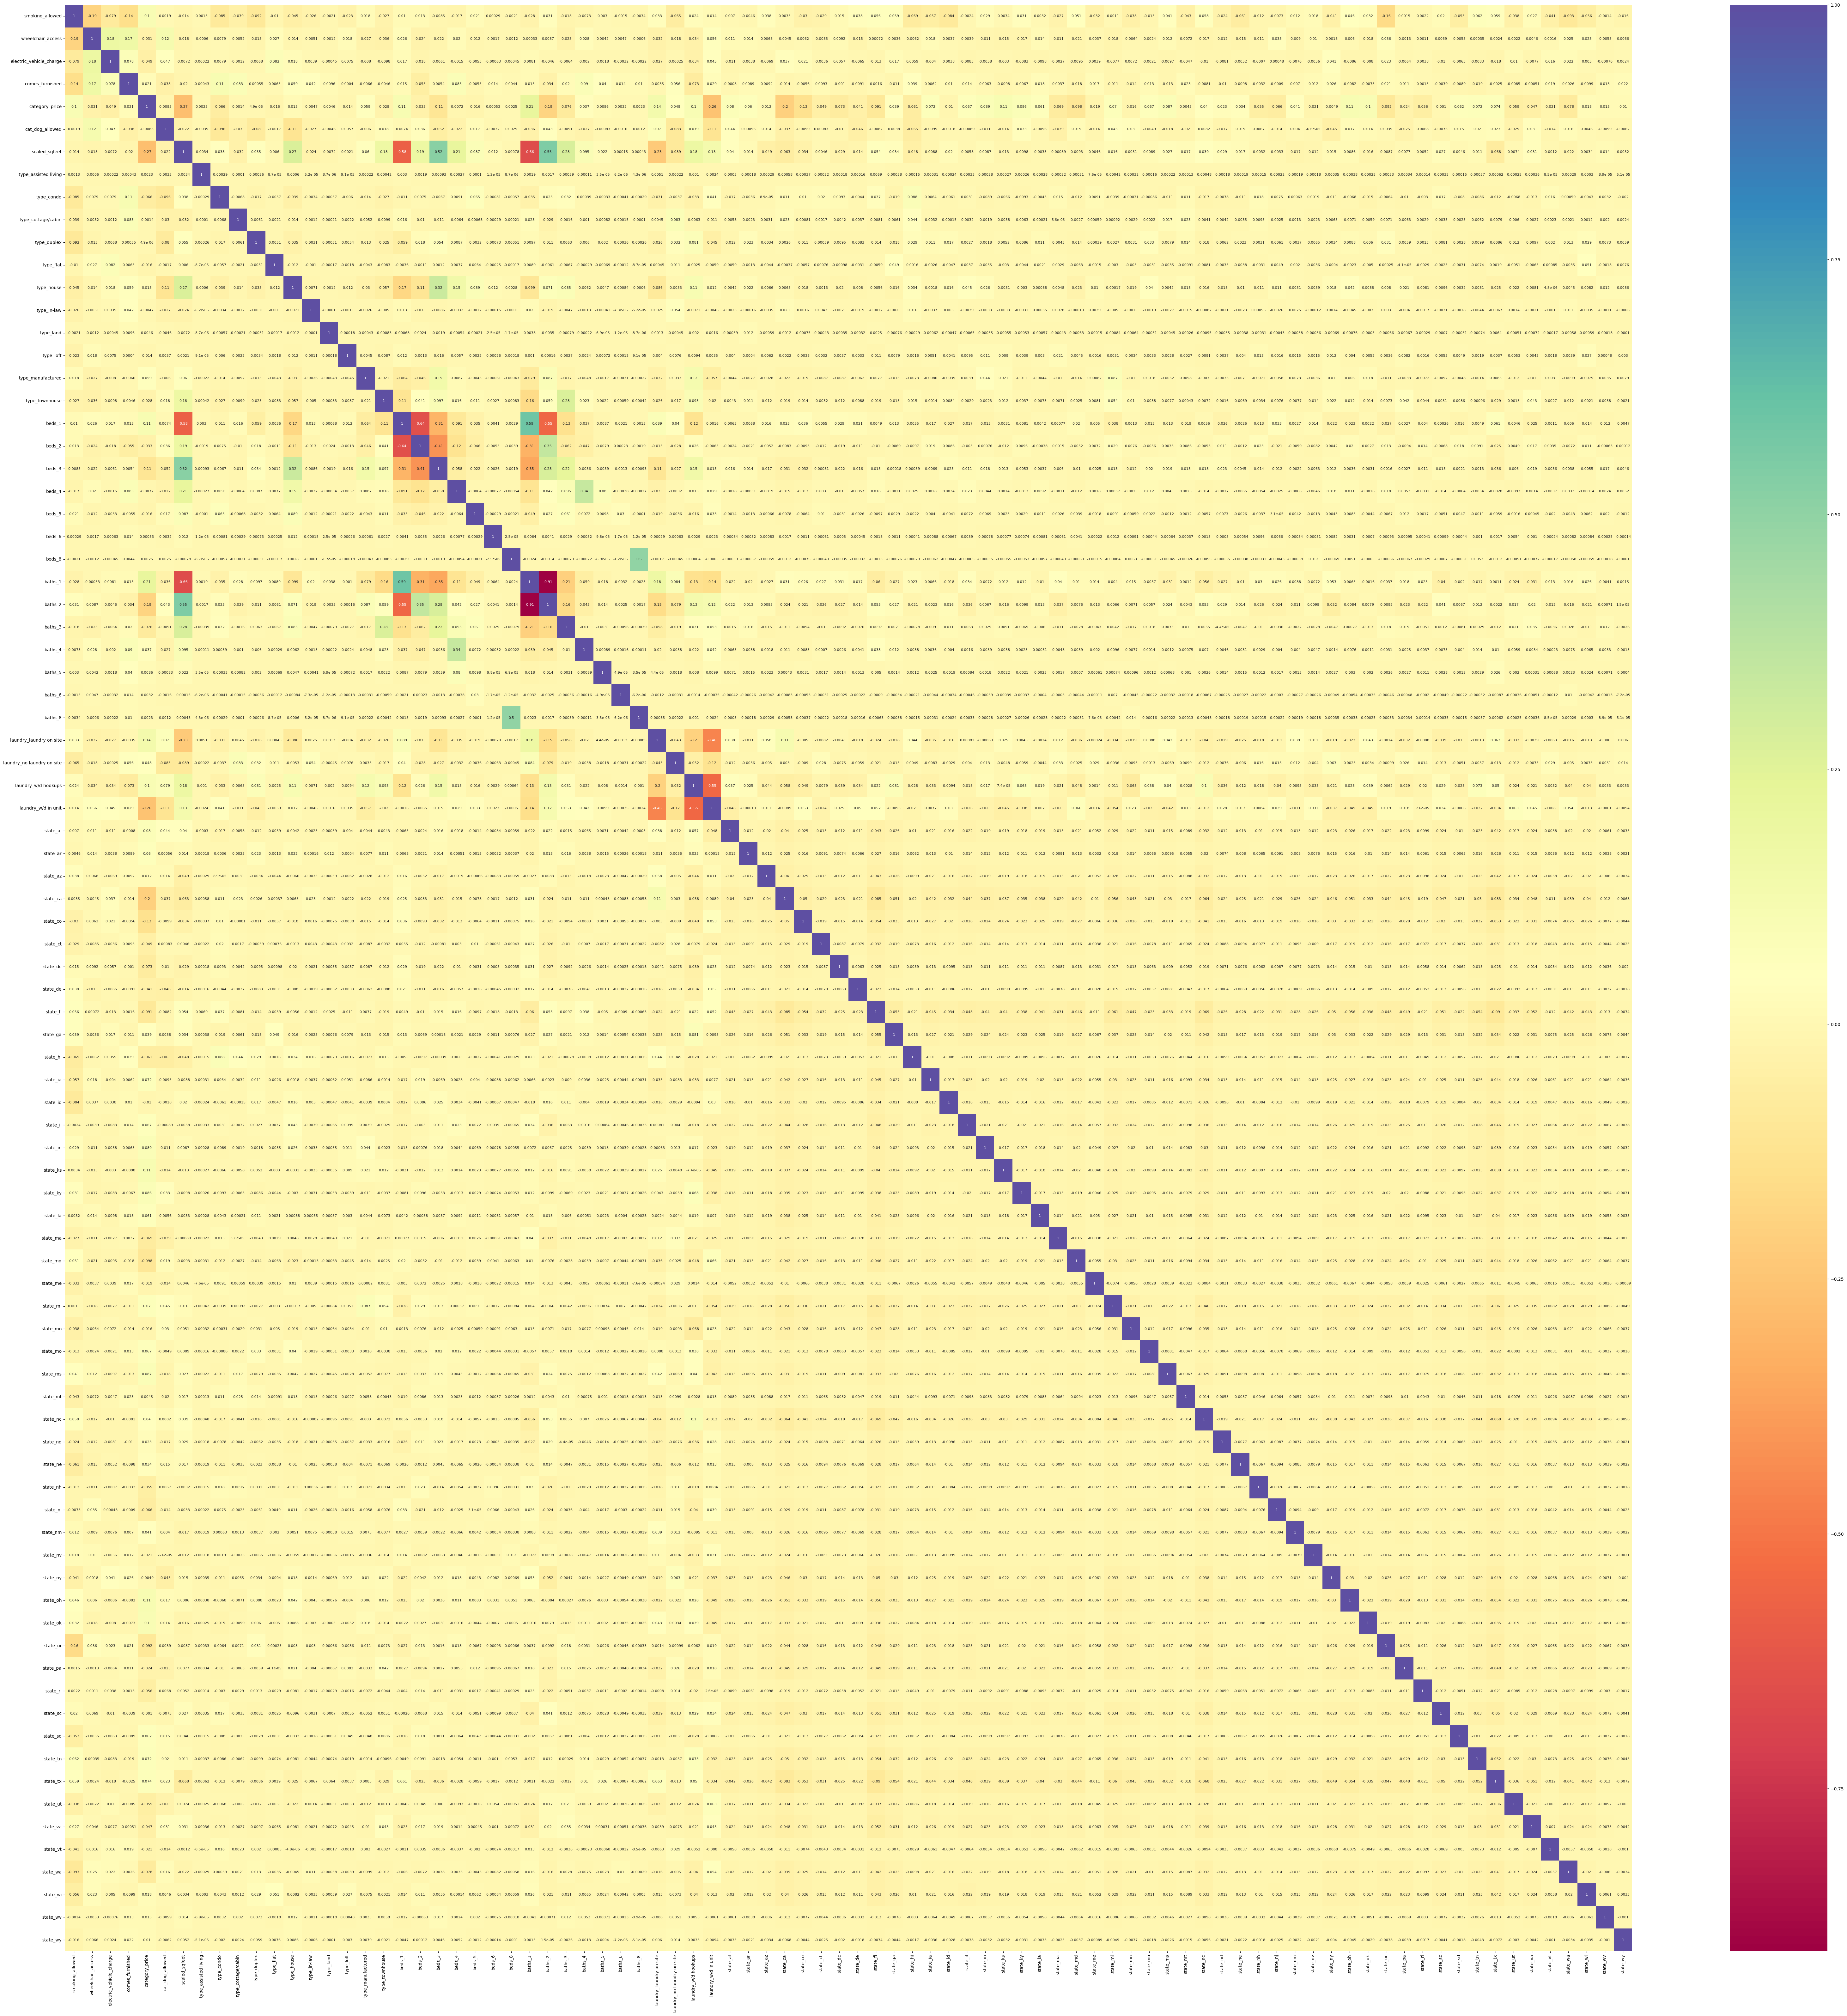

In [46]:
drop_features = ["type","sqfeet","beds","baths","cats_allowed","dogs_allowed","laundry_options","image_url","lat","long","state"]
df_eeuu = df_eeuu.drop(columns="price")
df_eeuu = df_eeuu.drop(columns=drop_features)
test_henry = test_henry.drop(columns=drop_features)

plt.figure(figsize=(80,80))
sns.heatmap(df_eeuu.corr(),annot=True,annot_kws={"size":8},cmap="Spectral")

Como resultado de este diagrama de correlacion:
 - vamos a redondear el valor de baths al entero inmediato, (ya esta hecho para este punto)
 - todas las demas variables no implican mayor problema de correlacion para los modelos

# Featuring Seleccition

In [56]:
from sklearn.model_selection import train_test_split

X = df_eeuu.drop(columns=["category_price"])
y = df_eeuu["category_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [57]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
coeficientes = clf.feature_importances_

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

d:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(229897, 14)

In [60]:
df_features = pd.concat([pd.Series(X.columns.to_list()),pd.Series(coeficientes)],axis=1)
df_features.columns = ["feature","coeficiente"]
df_features = df_features.sort_values(by=["coeficiente"],ascending=False)
df_features.reset_index(drop=True,inplace=True)
df_features["suma"] = df_features["coeficiente"].cumsum()
df_features.head(30)

feature  coeficiente      suma
0             scaled_sqfeet     0.398998  0.398998
1                  state_ca     0.050551  0.449549
2       laundry_w/d in unit     0.048795  0.498344
3                   baths_1     0.021419  0.519763
4           cat_dog_allowed     0.021337  0.541100
5                   baths_2     0.019793  0.560893
6                  state_co     0.019696  0.580589
7           smoking_allowed     0.019257  0.599846
8                type_house     0.016021  0.615866
9                  state_fl     0.013019  0.628886
10  laundry_laundry on site     0.012681  0.641566
11          comes_furnished     0.012232  0.653798
12      laundry_w/d hookups     0.012076  0.665874
13        wheelchair_access     0.011943  0.677817
14                 state_md     0.011482  0.689299
15                 state_ks     0.010674  0.699973
16                 state_or     0.010504  0.710477
17                   beds_3     0.010492  0.720969
18                   beds_1     0.010077  0.731046
19                   beds_2     0.010018  0.741065
20                 state_oh     0.009991  0.751056
21                 state_ma     0.009149  0.760206
22                 state_ok     0.008951  0.769156
23                 state_ia     0.007949  0.777105
24                 state_dc     0.007795  0.784900
25                 state_tx     0.007725  0.792624
26                 state_in     0.007693  0.800317
27           type_townhouse     0.007160  0.807477
28                 state_wa     0.006950  0.814427
29                 state_al     0.006771  0.821198

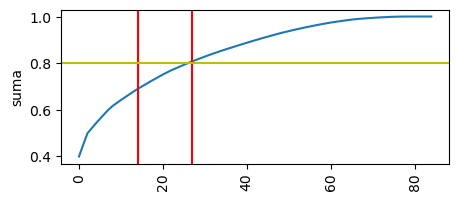

In [62]:
plt.figure(figsize=(5,2))
sns.lineplot(data=df_features, y=df_features["suma"],x=df_features.index)
plt.xticks(rotation=90)
plt.axvline(14,color="r")
plt.axvline(27,color="r")
plt.axhline(0.8,color="y")

Vamos a correr modelos con lo sugerido por kbest = 9 y con 18 que explican el 80% del modelo dado criterio propio.

In [ ]:
best_12 = df_features["feature"].iloc[0:9]
best_80_perc = df_features["feature"].iloc[0:18]

In [70]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,max_depth=4)
clf = clf.fit(X_train, y_train)
clf.feature_importances_

df_features = pd.concat([pd.Series(X.columns.to_list()),pd.Series(clf.feature_importances_)],axis=1)
df_features.columns = ["feature","coeficiente"]
df_features = df_features.sort_values(by=["coeficiente"],ascending=False)
df_features.reset_index(drop=True,inplace=True)
df_features["suma"] = df_features["coeficiente"].cumsum()
df_features.head(30)

feature  coeficiente      suma
0             scaled_sqfeet     0.168726  0.168726
1       laundry_w/d in unit     0.145492  0.314217
2                  state_ca     0.123312  0.437530
3                   baths_1     0.116918  0.554447
4                   baths_2     0.070127  0.624574
5                  state_co     0.060110  0.684684
6       laundry_w/d hookups     0.035408  0.720092
7   laundry_laundry on site     0.033208  0.753300
8                  state_ok     0.025428  0.778728
9                  state_oh     0.025396  0.804124
10                   beds_1     0.023319  0.827443
11                 state_ks     0.022599  0.850042
12                 state_md     0.021041  0.871083
13                   beds_3     0.020156  0.891238
14          smoking_allowed     0.014303  0.905542
15                 state_in     0.013967  0.919509
16                 state_ms     0.008140  0.927649
17                 state_or     0.007142  0.934791
18                  baths_3     0.006235  0.941026
19                 state_ky     0.005945  0.946971
20                 state_fl     0.005685  0.952656
21                 state_wa     0.005161  0.957817
22                 state_al     0.004668  0.962485
23        type_manufactured     0.004245  0.966730
24                 state_nj     0.003260  0.969990
25                 state_ma     0.003057  0.973047
26               type_house     0.003018  0.976065
27                 state_tn     0.002714  0.978778
28                 state_dc     0.002262  0.981041
29                 state_tx     0.002176  0.983217

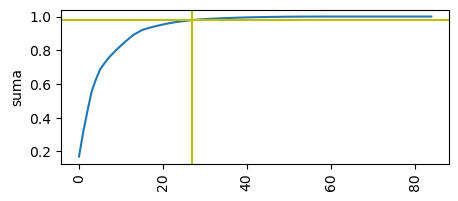

In [77]:
plt.figure(figsize=(5,2))
sns.lineplot(data=df_features, y=df_features["suma"],x=df_features.index)
plt.xticks(rotation=90)

plt.axhline(0.98,color="y")
plt.axvline(27,color="y")

como las columnas se repiten en gran mayoria, vamos a probar con las primeras 30 columnas del random forest.

In [83]:
best = df_features.head(30)["feature"].to_list()

## Machine Learning

In [79]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

### Regresion logistica

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model_rl = LogisticRegression()
scores = cross_val_score(model_rl, X_train[best], y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77     17528
           1       0.73      0.72      0.72     14658

    accuracy                           0.75     32186
   macro avg       0.75      0.75      0.75     32186
weighted avg       0.75      0.75      0.75     32186

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     17528
           1       0.72      0.72      0.72     14658

    accuracy                           0.75     32186
   macro avg       0.75      0.75      0.75     32186
weighted avg       0.75      0.75      0.75     32186

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     17527
           1       0.72      0.72      0.72     14658

    accuracy                           0.75     32185
   macro avg       0.75      0.75      0.75     32185
weighted avg       0.75      0.75      0.75     32185

              preci

### Decision Tree

In [85]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train[best], y_train)
scores = cross_val_score(clf, X_train[best], y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73     17528
           1       0.68      0.56      0.62     14658

    accuracy                           0.68     32186
   macro avg       0.68      0.67      0.67     32186
weighted avg       0.68      0.68      0.68     32186

              precision    recall  f1-score   support

           0       0.66      0.85      0.74     17528
           1       0.73      0.48      0.58     14658

    accuracy                           0.68     32186
   macro avg       0.70      0.67      0.66     32186
weighted avg       0.69      0.68      0.67     32186

              precision    recall  f1-score   support

           0       0.67      0.85      0.75     17527
           1       0.73      0.49      0.59     14658

    accuracy                           0.68     32185
   macro avg       0.70      0.67      0.67     32185
weighted avg       0.69      0.68      0.67     32185

              preci

### RandomForest

In [86]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,max_depth=4)
rf = rf.fit(X_train[best], y_train)
scores = cross_val_score(rf, X_train[best], y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76     17528
           1       0.74      0.58      0.65     14658

    accuracy                           0.72     32186
   macro avg       0.72      0.70      0.70     32186
weighted avg       0.72      0.72      0.71     32186

              precision    recall  f1-score   support

           0       0.70      0.84      0.76     17528
           1       0.74      0.57      0.64     14658

    accuracy                           0.71     32186
   macro avg       0.72      0.70      0.70     32186
weighted avg       0.72      0.71      0.71     32186

              precision    recall  f1-score   support

           0       0.70      0.83      0.76     17527
           1       0.74      0.58      0.65     14658

    accuracy                           0.72     32185
   macro avg       0.72      0.70      0.71     32185
weighted avg       0.72      0.72      0.71     32185

              preci

### knears neighbors

In [87]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_train[best], y_train)
scores = cross_val_score(neigh, X_train[best], y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     17528
           1       0.78      0.79      0.78     14658

    accuracy                           0.80     32186
   macro avg       0.80      0.80      0.80     32186
weighted avg       0.80      0.80      0.80     32186

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     17528
           1       0.79      0.79      0.79     14658

    accuracy                           0.81     32186
   macro avg       0.80      0.80      0.80     32186
weighted avg       0.81      0.81      0.81     32186

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     17527
           1       0.79      0.79      0.79     14658

    accuracy                           0.81     32185
   macro avg       0.81      0.81      0.81     32185
weighted avg       0.81      0.81      0.81     32185

              preci

### Naive Bayes

In [88]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train[best],y_train)
scores = cross_val_score(gnb, X_train[best], y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72     17528
           1       0.66      0.79      0.72     14658

    accuracy                           0.72     32186
   macro avg       0.73      0.73      0.72     32186
weighted avg       0.73      0.72      0.72     32186

              precision    recall  f1-score   support

           0       0.79      0.66      0.72     17528
           1       0.66      0.79      0.72     14658

    accuracy                           0.72     32186
   macro avg       0.72      0.72      0.72     32186
weighted avg       0.73      0.72      0.72     32186

              precision    recall  f1-score   support

           0       0.79      0.65      0.72     17527
           1       0.66      0.80      0.72     14658

    accuracy                           0.72     32185
   macro avg       0.72      0.72      0.72     32185
weighted avg       0.73      0.72      0.72     32185

              preci

### ADA

In [89]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train[best],y_train)
scores = cross_val_score(ada, X_train[best], y_train, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))


              precision    recall  f1-score   support

           0       0.77      0.78      0.77     17528
           1       0.73      0.72      0.72     14658

    accuracy                           0.75     32186
   macro avg       0.75      0.75      0.75     32186
weighted avg       0.75      0.75      0.75     32186

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     17528
           1       0.73      0.72      0.72     14658

    accuracy                           0.75     32186
   macro avg       0.75      0.75      0.75     32186
weighted avg       0.75      0.75      0.75     32186

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     17527
           1       0.73      0.72      0.72     14658

    accuracy                           0.75     32185
   macro avg       0.75      0.75      0.75     32185
weighted avg       0.75      0.75      0.75     32185

              preci

# habilitando dataset test para enviar a Henry

In [ ]:
test_henry["scaled_sqfeet"] = scaler.transform(np.array(test_henry["sqfeet"]).reshape(-1,1))
test_henry["cat_dog_allowed"] = test_henry.apply(animales,axis=1)
ohe1 = pd.get_dummies(test_henry["laundry_options"],prefix="laundry")
ohe2 = pd.get_dummies(test_henry["type"],prefix="type")
ohe3 = pd.get_dummies(test_henry["state"],prefix="state")


test_henry_tot = pd.concat([test_henry,ohe1,ohe2,ohe3],axis=1)

In [ ]:
drop_features_test_henry = drop_features.copy()
drop_features_test_henry.remove('geometry')
drop_features_test_henry.remove('price/sqfeet')
drop_features_test_henry.remove('price')



In [ ]:
test_henry_tot.drop(drop_features_test_henry,axis=1,inplace=True)
test_henry_tot["type_assisted living"] = 0
test_henry_tot["type_land"] = 0

In [ ]:
y_pred = neigh_best.predict(test_henry_tot[X_train.columns.to_list()])

In [ ]:
y_pred

In [ ]:
pd.Series(y_pred).to_csv("fwong90.csv",index=False)